In [74]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law
import numpy as np
import sys
sys.path.append("..")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import seaborn as sns

## Loading Trained Weights

In [75]:
with open('../weights/SIN2_wt_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [76]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight'])

In [77]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

# test oja
# weight_sums = np.array(weight_history['weight_sums'])
# gain_changes = np.array(weight_history['gain_changes'])

In [78]:
weight_matrix

array([[ 0.        ,  0.67194736,  0.59555846, ..., -0.47203702,
        -0.66475493, -0.35503861],
       [ 0.84311152,  0.        ,  0.83444411, ..., -1.12863934,
        -0.40847433, -0.2425092 ],
       [ 0.52651042,  0.10652715, -0.        , ..., -0.61065269,
        -0.39148399, -0.07126686],
       ...,
       [ 0.58963889,  0.58924735,  1.71329546, ...,  0.        ,
        -0.54463851, -0.96519899],
       [ 0.        ,  0.15844157,  0.        , ..., -0.76055521,
        -0.        , -0.40584317],
       [ 0.60453779,  0.94082493,  1.50878847, ..., -0.32790709,
        -0.22748248,  0.        ]])

In [79]:
output_weight_matrix

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.]])

In [80]:
np.max(weight_matrix)

2.8474161624908447

<Axes: >

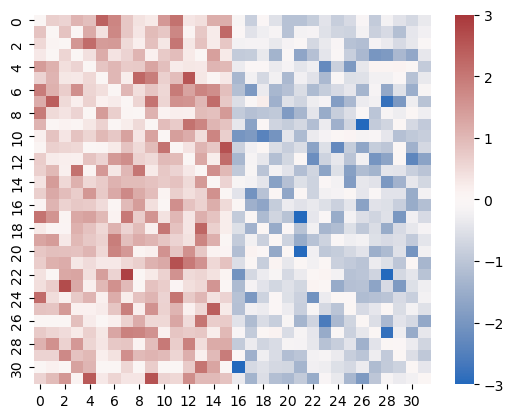

In [81]:
sns.heatmap(weight_matrix, vmax=3, vmin=-3, cmap='vlag')

In [82]:
excite_weights = weight_matrix * (weight_matrix > 0)
# sns.heatmap(excite_weights, vmax=1, vmin=-1, cmap='vlag')

In [83]:
np.sum(excite_weights)

418.5576494922928

In [84]:
inhibit_weights = weight_matrix * (weight_matrix < 0)
np.sum(inhibit_weights)

-375.4274178715423

In [85]:
# estimate oja's alpha
1 / np.linalg.norm(excite_weights, None)**2

0.0018812581750585159

## Defining Network

In [86]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 400
time = ndata * timestep #ms
num_inputs = 1
num_nodes = 32
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep, 
                # output_nonlinearity=nn.Sigmoid()
                )

100%|██████████| 400/400 [00:00<00:00, 24850.72it/s]


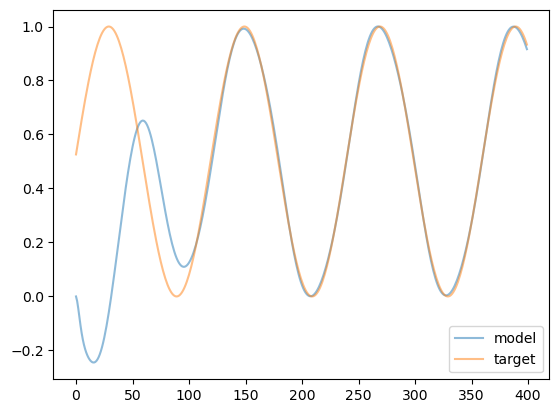

In [87]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

outputs, activations = network.simulate(time, torch.tensor(inputs).float())
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
# plt.plot(time_points, inputs)
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_train.png")

100%|██████████| 300/300 [00:00<00:00, 24366.60it/s]


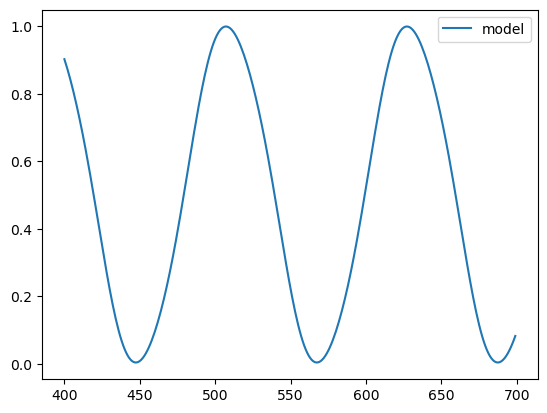

In [88]:
time_pred = 3000
time_points_pred = np.arange(400,700).reshape(-1, 1)
inputs_pred = (1 + np.sin(time_points_pred/60*np.pi))/2

outputs_pred, activations_pred = network.simulate(time_pred, torch.tensor(inputs_pred).float())
fig, ax = plt.subplots()
plt.plot(time_points_pred, outputs_pred.detach().numpy(), label='model')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_pred.png")

(0.0, 0.1)

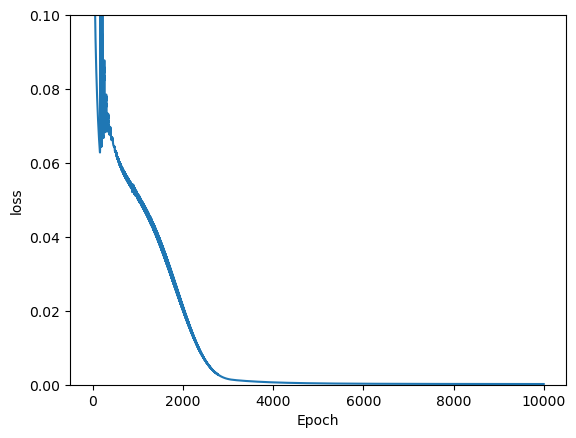

In [89]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.1])
# plt.savefig("fig/sin_oja_loss.png")